# Hate Speech Detection

## Import library

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer 
from sklearn.utils import resample
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics, utils
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import re
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
df = pd.read_csv("train_tweets.csv")
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
hate_tweet = df[df.label == 1]
hate_tweet.head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...


In [ ]:
nothate_tweet = df[df.label == 0]
nothate_tweet.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# Data Preprocessing

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df['tweet'].isna().sum()

0

In [ ]:
nltk.download('stopwords')
eng_stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
lemmatizer = WordNetLemmatizer() 

In [ ]:
def process_message(review_text):
    # remove all the special characters
    new_review_text = re.sub("[^a-zA-Z]", " ",review_text) 
    # convert all letters to lower case
    words = new_review_text.lower().split()
    # remove stop words
    words = [w for w in words if not w in eng_stops]    
    # lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (" ".join(words))

In [ ]:
df['cleaned_tweets']=df['tweet'].apply(lambda x: process_message(x))

In [ ]:
df.head()

,id,label,tweet,cleaned_tweets
0,1,0,@user when a father is dysfunctional and is s...,user father dysfunctional selfish drag kid dys...
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks lyft credit use cause offer w...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur
4,5,0,factsguide: society now #motivation,factsguide society motivation


## Visualization

In [ ]:
# Data balance
def createPieChartFor(t_df):
    Lst = 100*t_df.value_counts()/len(t_df)
    
    # set data for pie chart
    labels = t_df.value_counts().index.values
    sizes =  Lst 
    
    # set labels
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

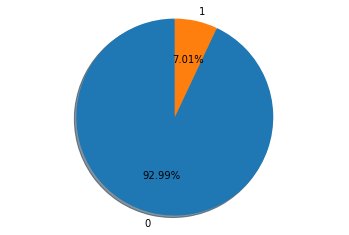

In [ ]:
createPieChartFor(df.label)

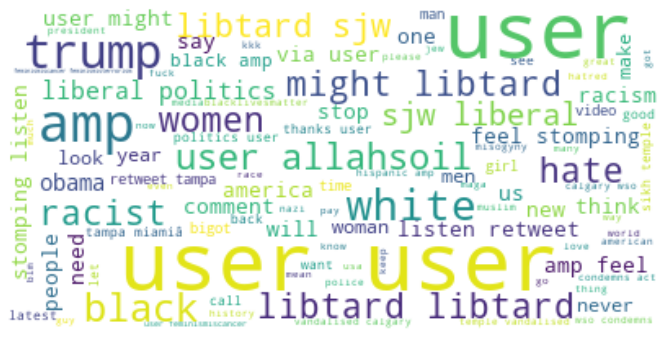

In [ ]:
# Hate Word clouds
text = " ".join(review for review in hate_tweet.tweet)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

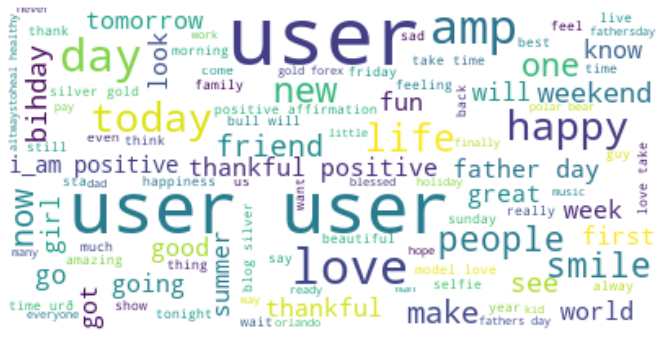

In [ ]:
# Not a hate Word clouds
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(review for review in nothate_tweet.tweet)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Handling Imbalanced data

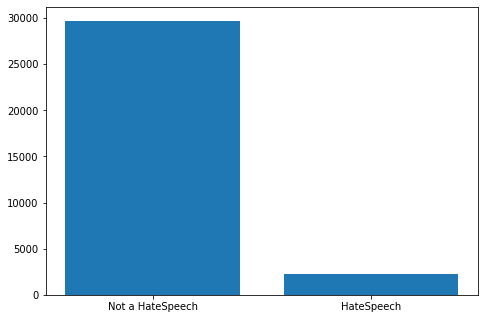

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Not a HateSpeech','HateSpeech']
data = [len(df[df.label==0]),len(df[df.label==1])]
ax.bar(langs,data)
plt.show()

## Over Sampling

In [ ]:
df_majority = df[df.label==0]
df_minority = df[df.label==1]
df_minority_oversampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples=len(df_majority),   
                                 random_state=123)
df_oversampled = pd.concat([df_minority_oversampled, df_majority])
df_oversampled['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

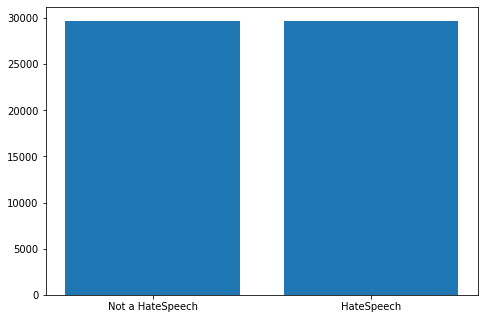

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Not a HateSpeech','HateSpeech']
data = [len(df_oversampled[df_oversampled.label==0]),len(df_oversampled[df_oversampled.label==1])]
ax.bar(langs,data)
plt.show()

## Spliting the data

In [ ]:
# Split data into training and test sets
X = df_oversampled['cleaned_tweets']
y = df_oversampled['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = None)

# Feature Extraction
## CountVectorizer
## Tfidf

In [ ]:
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [ ]:
x_train_cv = count_vect.fit_transform(X_train)
x_train_tfidf = transformer.fit_transform(x_train_cv)

In [ ]:
print(x_train_cv.shape)
print(x_train_tfidf.shape)

(47552, 30730)
(47552, 30730)


In [ ]:
x_test_cv = count_vect.transform(X_test)
x_test_tfidf = transformer.transform(x_test_cv)

In [ ]:
print(x_test_cv.shape)
print(x_test_tfidf.shape)

(11888, 30730)
(11888, 30730)


# Model Building
## MLP Model with CV

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp_cv_model = MLPClassifier(max_iter=500, activation='relu',random_state=42)

In [ ]:
mlp_cv_model.fit(x_train_cv,y_train)

MLPClassifier(max_iter=500, random_state=42)

In [ ]:
mlp_cv_predict = mlp_cv_model.predict(x_test_cv)

In [ ]:
print(confusion_matrix(y_test,mlp_cv_predict))
print(classification_report(y_test, mlp_cv_predict))

[[5645  256]
 [   9 5978]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      5901
           1       0.96      1.00      0.98      5987

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



In [ ]:
f1_mlp_cv = f1_score(y_test, mlp_cv_predict)

In [ ]:
pr_mlp_cv = metrics.precision_score(y_test, mlp_cv_predict)

In [ ]:
rc_mlp_cv = metrics.recall_score(y_test, mlp_cv_predict)

In [ ]:
acc_mlp_cv = metrics.accuracy_score(y_test, mlp_cv_predict)

## AdaBoost Model with CV

In [ ]:
ad_cv_model = AdaBoostClassifier(n_estimators=500, random_state=42)

In [ ]:
ad_cv_model.fit(x_train_cv,y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [ ]:
ad_cv_predict = ad_cv_model.predict(x_test_cv)

In [ ]:
print(confusion_matrix(y_test,ad_cv_predict))
print(classification_report(y_test, ad_cv_predict))

[[5549  352]
 [ 570 5417]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      5901
           1       0.94      0.90      0.92      5987

    accuracy                           0.92     11888
   macro avg       0.92      0.92      0.92     11888
weighted avg       0.92      0.92      0.92     11888



In [ ]:
f1_ad_cv = f1_score(y_test, ad_cv_predict)

In [ ]:
pr_ad_cv = metrics.precision_score(y_test, ad_cv_predict)

In [ ]:
rc_ad_cv = metrics.recall_score(y_test, ad_cv_predict)

In [ ]:
acc_ad_cv = metrics.accuracy_score(y_test, ad_cv_predict)

## XGBoost Model with CV

In [ ]:
xgb_cv_model = XGBClassifier(random_state=42,learning_rate=0.9)
xgb_cv_model.fit(x_train_cv,y_train)

XGBClassifier(learning_rate=0.9, random_state=42)

In [ ]:
xgb_cv_predict = xgb_cv_model.predict(x_test_cv)

In [ ]:
print(confusion_matrix(y_test,xgb_cv_predict))
print(classification_report(y_test,xgb_cv_predict))

[[5514  387]
 [ 809 5178]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5901
           1       0.93      0.86      0.90      5987

    accuracy                           0.90     11888
   macro avg       0.90      0.90      0.90     11888
weighted avg       0.90      0.90      0.90     11888



In [ ]:
f1_xgb_cv = f1_score(y_test, xgb_cv_predict)

In [ ]:
pr_xgb_cv = metrics.precision_score(y_test, xgb_cv_predict)

In [ ]:
rc_xgb_cv = metrics.recall_score(y_test, xgb_cv_predict)

In [ ]:
acc_xgb_cv = metrics.accuracy_score(y_test, xgb_cv_predict)

## MultinomialNB Model with CV

In [ ]:
nb_cv_model = MultinomialNB()
nb_cv_model.fit(x_train_cv, y_train)

MultinomialNB()

In [ ]:
nb_cv_predict = nb_cv_model.predict(x_test_cv)

In [ ]:
print(confusion_matrix(y_test,nb_cv_predict))
print(classification_report(y_test, nb_cv_predict))

[[5416  485]
 [ 112 5875]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      5901
           1       0.92      0.98      0.95      5987

    accuracy                           0.95     11888
   macro avg       0.95      0.95      0.95     11888
weighted avg       0.95      0.95      0.95     11888



In [ ]:
f1_nb_cv = f1_score(y_test, nb_cv_predict)

In [ ]:
pr_nb_cv = metrics.precision_score(y_test, nb_cv_predict)

In [ ]:
rc_nb_cv = metrics.recall_score(y_test, nb_cv_predict)

In [ ]:
acc_nb_cv = metrics.accuracy_score(y_test, nb_cv_predict)

## Comparison of cv models with F1 scores,accuracy,precision and recall

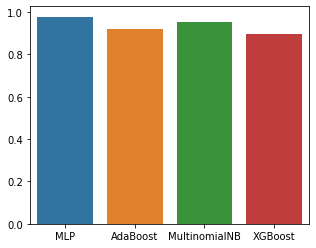

In [ ]:
cv_models = ['MLP','AdaBoost', 'MultinomialNB', "XGBoost"]
f1_cv_models = [f1_mlp_cv,f1_ad_cv, f1_nb_cv, f1_xgb_cv]

plt.figure(figsize=(5,4))
sns.barplot(x = cv_models, y= f1_cv_models)

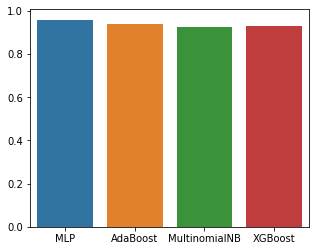

In [ ]:
cv_models = ['MLP','AdaBoost', 'MultinomialNB', "XGBoost"]
pr_cv_models = [pr_mlp_cv,pr_ad_cv, pr_nb_cv, pr_xgb_cv]

plt.figure(figsize=(5,4))
sns.barplot(x = cv_models, y= pr_cv_models)

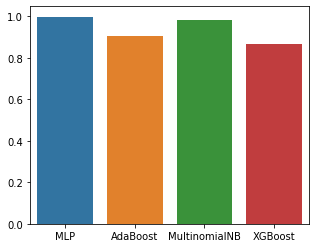

In [ ]:
cv_models = ['MLP','AdaBoost', 'MultinomialNB', "XGBoost"]
rc_cv_models = [rc_mlp_cv,rc_ad_cv, rc_nb_cv, rc_xgb_cv]

plt.figure(figsize=(5,4))
sns.barplot(x = cv_models, y= rc_cv_models)

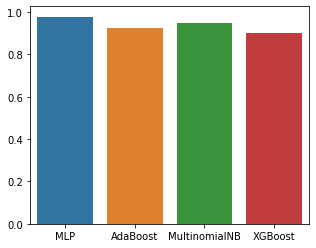

In [ ]:
cv_models = ['MLP','AdaBoost', 'MultinomialNB', "XGBoost"]
acc_cv_models = [acc_mlp_cv,acc_ad_cv, acc_nb_cv, acc_xgb_cv]

plt.figure(figsize=(5,4))
sns.barplot(x = cv_models, y= acc_cv_models)

## MLP Model with tfidf

In [ ]:
mlp_tfidf_model = MLPClassifier(max_iter=500, activation='relu',random_state=42)

In [ ]:
mlp_tfidf_model.fit(x_train_tfidf,y_train)

MLPClassifier(max_iter=500, random_state=42)

In [ ]:
mlp_tfidf_predict = mlp_tfidf_model.predict(x_test_tfidf)

In [ ]:
print(confusion_matrix(y_test,mlp_tfidf_predict))
print(classification_report(y_test, mlp_tfidf_predict))

[[5702  199]
 [  12 5975]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      5901
           1       0.97      1.00      0.98      5987

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



In [ ]:
f1_mlp_tfidf = f1_score(y_test, mlp_tfidf_predict)

In [ ]:
pr_mlp_tfidf = metrics.precision_score(y_test, mlp_tfidf_predict)

In [ ]:
rc_mlp_tfidf = metrics.recall_score(y_test, mlp_tfidf_predict)

In [ ]:
acc_mlp_tfidf = metrics.accuracy_score(y_test, mlp_tfidf_predict)

## AdaBoost  Model with tf-idf

In [ ]:
ad_tfidf_model = AdaBoostClassifier(n_estimators=500, random_state=42)
ad_tfidf_model.fit(x_train_tfidf,y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [ ]:
ad_tfidf_predict = ad_tfidf_model.predict(x_test_tfidf)

In [ ]:
print(confusion_matrix(y_test,ad_tfidf_predict))
print(classification_report(y_test, ad_tfidf_predict))

[[5510  391]
 [ 451 5536]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      5901
           1       0.93      0.92      0.93      5987

    accuracy                           0.93     11888
   macro avg       0.93      0.93      0.93     11888
weighted avg       0.93      0.93      0.93     11888



In [ ]:
f1_ad_tfidf = f1_score(y_test, ad_tfidf_predict)

In [ ]:
pr_ad_tfidf = metrics.precision_score(y_test, ad_tfidf_predict)

In [ ]:
rc_ad_tfidf = metrics.recall_score(y_test, ad_tfidf_predict)

In [ ]:
acc_ad_tfidf = metrics.accuracy_score(y_test, ad_tfidf_predict)

## XGBoost Model with tf-idf

In [ ]:
xgb_tfidf_model = XGBClassifier(random_state=42,learning_rate=0.9)
xgb_tfidf_model.fit(x_train_tfidf,y_train)

XGBClassifier(learning_rate=0.9, random_state=42)

In [ ]:
xgb_tfidf_predict = xgb_tfidf_model.predict(x_test_tfidf)

In [ ]:
print(confusion_matrix(y_test,xgb_tfidf_predict))
print(classification_report(y_test,xgb_tfidf_predict))

[[5387  514]
 [ 611 5376]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      5901
           1       0.91      0.90      0.91      5987

    accuracy                           0.91     11888
   macro avg       0.91      0.91      0.91     11888
weighted avg       0.91      0.91      0.91     11888



In [ ]:
f1_xgb_tfidf = f1_score(y_test, xgb_tfidf_predict)

In [ ]:
pr_xgb_tfidf = metrics.precision_score(y_test, xgb_tfidf_predict)

In [ ]:
rc_xgb_tfidf = metrics.recall_score(y_test, xgb_tfidf_predict)

In [ ]:
acc_xgb_tfidf = metrics.accuracy_score(y_test, xgb_tfidf_predict)

## MultinomialNB Model with tf-idf

In [ ]:
nb_tfidf_model = MultinomialNB()
nb_tfidf_model.fit(x_train_tfidf, y_train)

MultinomialNB()

In [ ]:
nb_tfidf_predict = nb_tfidf_model.predict(x_test_tfidf)

In [ ]:
print(confusion_matrix(y_test,nb_tfidf_predict))
print(classification_report(y_test, nb_tfidf_predict))

[[5397  504]
 [  91 5896]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      5901
           1       0.92      0.98      0.95      5987

    accuracy                           0.95     11888
   macro avg       0.95      0.95      0.95     11888
weighted avg       0.95      0.95      0.95     11888



In [ ]:
f1_nb_tfidf = f1_score(y_test, nb_tfidf_predict)

In [ ]:
pr_nb_tfidf = metrics.precision_score(y_test, nb_tfidf_predict)

In [ ]:
rc_nb_tfidf = metrics.recall_score(y_test, nb_tfidf_predict)

In [ ]:
acc_nb_tfidf = metrics.accuracy_score(y_test, nb_tfidf_predict)

## Comparison of tfidf models with F1 scores,accuracy,precision and recall

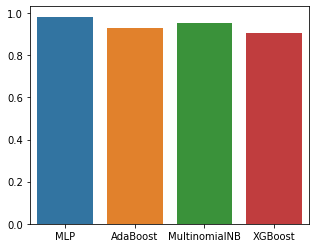

In [ ]:
tfidf_models = ['MLP','AdaBoost', 'MultinomialNB', "XGBoost"]
f1_tfidf_models = [f1_mlp_tfidf,f1_ad_tfidf, f1_nb_tfidf, f1_xgb_tfidf]

plt.figure(figsize=(5,4))
sns.barplot(x = tfidf_models, y= f1_tfidf_models)

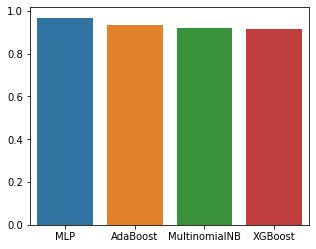

In [ ]:
tfidf_models = ['MLP','AdaBoost', 'MultinomialNB', "XGBoost"]
pr_tfidf_models = [pr_mlp_tfidf,pr_ad_tfidf, pr_nb_tfidf, pr_xgb_tfidf]

plt.figure(figsize=(5,4))
sns.barplot(x = tfidf_models, y= pr_tfidf_models)

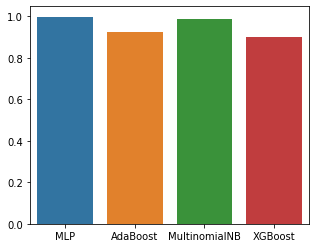

In [ ]:
tfidf_models = ['MLP','AdaBoost', 'MultinomialNB', "XGBoost"]
rc_tfidf_models = [rc_mlp_tfidf,rc_ad_tfidf, rc_nb_tfidf, rc_xgb_tfidf]

plt.figure(figsize=(5,4))
sns.barplot(x = tfidf_models, y= rc_tfidf_models)

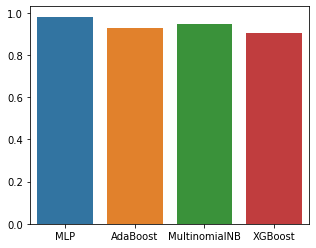

In [ ]:
tfidf_models = ['MLP','AdaBoost', 'MultinomialNB', "XGBoost"]
acc_tfidf_models = [acc_mlp_tfidf,acc_ad_tfidf, acc_nb_tfidf, acc_xgb_tfidf]

plt.figure(figsize=(5,4))
sns.barplot(x = tfidf_models, y= acc_tfidf_models)

## ROC Curve Classifiers of cv

In [ ]:
print('MLP Score: ', roc_auc_score(y_test, mlp_cv_predict))
print('AdaBoost Score: ', roc_auc_score(y_test, ad_cv_predict))
print('MultinomialNB Score: ', roc_auc_score(y_test, nb_cv_predict))
print('XG Boost Score: ', roc_auc_score(y_test, xgb_cv_predict))

MLP Score:  0.9775571326984324
AdaBoost Score:  0.9225714065500388
MultinomialNB Score:  0.949551670827662
XG Boost Score:  0.8996458943538828


In [ ]:
mlp_fpr, mlp_tpr, threshold = roc_curve(y_test,mlp_cv_predict)
ad_fpr, ad_tpr, threshold = roc_curve(y_test,ad_cv_predict)
nb_fpr, nb_tpr, threshold = roc_curve(y_test, nb_cv_predict)
xgb_fpr, xgb_tpr, thresold = roc_curve(y_test, xgb_cv_predict)

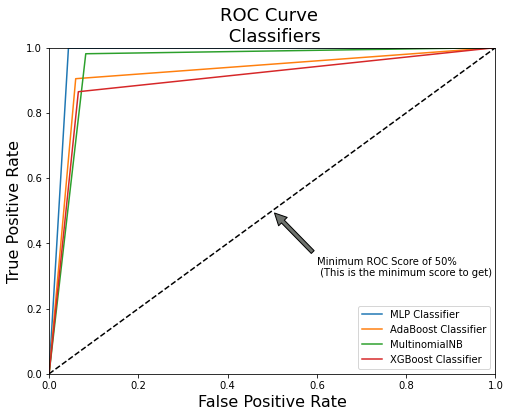

In [ ]:
def graph_roc_curve_multiple(mlp_fpr, mlp_tpr,ad_fpr, ad_tpr, nb_fpr, nb_tpr,xgb_fpr, xgb_tpr):
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve \n Classifiers', fontsize=18)
    plt.plot(mlp_fpr, mlp_tpr, label='MLP Classifier')
    plt.plot(ad_fpr, ad_tpr, label='AdaBoost Classifier')
    plt.plot(nb_fpr, nb_tpr, label='MultinomialNB')
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Classifier')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(mlp_fpr, mlp_tpr,ad_fpr, ad_tpr, nb_fpr, nb_tpr, xgb_fpr, xgb_tpr)
plt.show()

## ROC Curve Classifiers of Tf-Idf

In [ ]:
print('MLP Score: ', roc_auc_score(y_test, mlp_tfidf_predict))
print('AdaBoost Score: ', roc_auc_score(y_test, ad_tfidf_predict))
print('MultinomialNB Score: ', roc_auc_score(y_test, nb_tfidf_predict))
print('XG Boost Score: ', roc_auc_score(y_test, xgb_tfidf_predict))

MLP Score:  0.9821362797386769
AdaBoost Score:  0.9292050813253038
MultinomialNB Score:  0.9496955740997547
XG Boost Score:  0.9054208339953196


In [ ]:
mlp_fpr, mlp_tpr, threshold = roc_curve(y_test,mlp_tfidf_predict)
ad_fpr, ad_tpr, threshold = roc_curve(y_test,ad_tfidf_predict)
nb_fpr, nb_tpr, threshold = roc_curve(y_test, nb_tfidf_predict)
xgb_fpr, xgb_tpr, thresold = roc_curve(y_test, xgb_tfidf_predict)

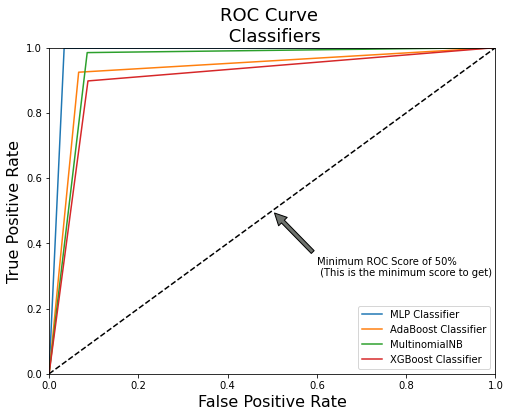

In [ ]:
def graph_roc_curve_multiple(mlp_fpr, mlp_tpr,ad_fpr, ad_tpr, nb_fpr, nb_tpr,xgb_fpr, xgb_tpr):
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve \n Classifiers', fontsize=18)
    plt.plot(mlp_fpr, mlp_tpr, label='MLP Classifier')
    plt.plot(ad_fpr, ad_tpr, label='AdaBoost Classifier')
    plt.plot(nb_fpr, nb_tpr, label='MultinomialNB')
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Classifier')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(mlp_fpr, mlp_tpr,ad_fpr, ad_tpr, nb_fpr, nb_tpr, xgb_fpr, xgb_tpr)
plt.show()

In [ ]:
file_name = 'final_tweets.csv'
df.to_csv(file_name,index=False)